In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

# This will open a file picker dialog
print("Please upload your kaggle.json file")
uploaded = files.upload()

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:16<00:00, 146MB/s]
100% 2.29G/2.29G [00:17<00:00, 140MB/s]


In [ ]:
!unzip -q chest-xray-pneumonia.zip -d /content/dataset

In [ ]:
import os
print(os.listdir('/content/dataset/chest_xray'))
print("Train classes:", os.listdir('/content/dataset/chest_xray/train'))
print("Sample train NORMAL image count:", len(os.listdir('/content/dataset/chest_xray/train/NORMAL')))
print("Sample train PNEUMONIA image count:", len(os.listdir('/content/dataset/chest_xray/train/PNEUMONIA')))

['test', 'chest_xray', '__MACOSX', 'val', 'train']
Train classes: ['PNEUMONIA', 'NORMAL']
Sample train NORMAL image count: 1341
Sample train PNEUMONIA image count: 3875


In [ ]:
#Stage 2: Data Exploration & Preprocessing

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
# Step 1: Explore Folder Structure & Class Distribution
data_dir = '/content/dataset/chest_xray'

def count_images(folder):
    normal = len(os.listdir(os.path.join(folder, 'NORMAL')))
    pneumonia = len(os.listdir(os.path.join(folder, 'PNEUMONIA')))
    return normal, pneumonia

train_normal, train_pneu = count_images(os.path.join(data_dir, 'train'))
val_normal, val_pneu = count_images(os.path.join(data_dir, 'val'))
test_normal, test_pneu = count_images(os.path.join(data_dir, 'test'))

print(f"{'Split':<10} {'NORMAL':<10} {'PNEUMONIA':<10}")
print(f"{'-'*35}")
print(f"{'Train':<10} {train_normal:<10} {train_pneu:<10}")
print(f"{'Val':<10} {val_normal:<10} {val_pneu:<10}")
print(f"{'Test':<10} {test_normal:<10} {test_pneu:<10}")

Split      NORMAL     PNEUMONIA 
-----------------------------------
Train      1341       3875      
Val        8          8         
Test       234        390       


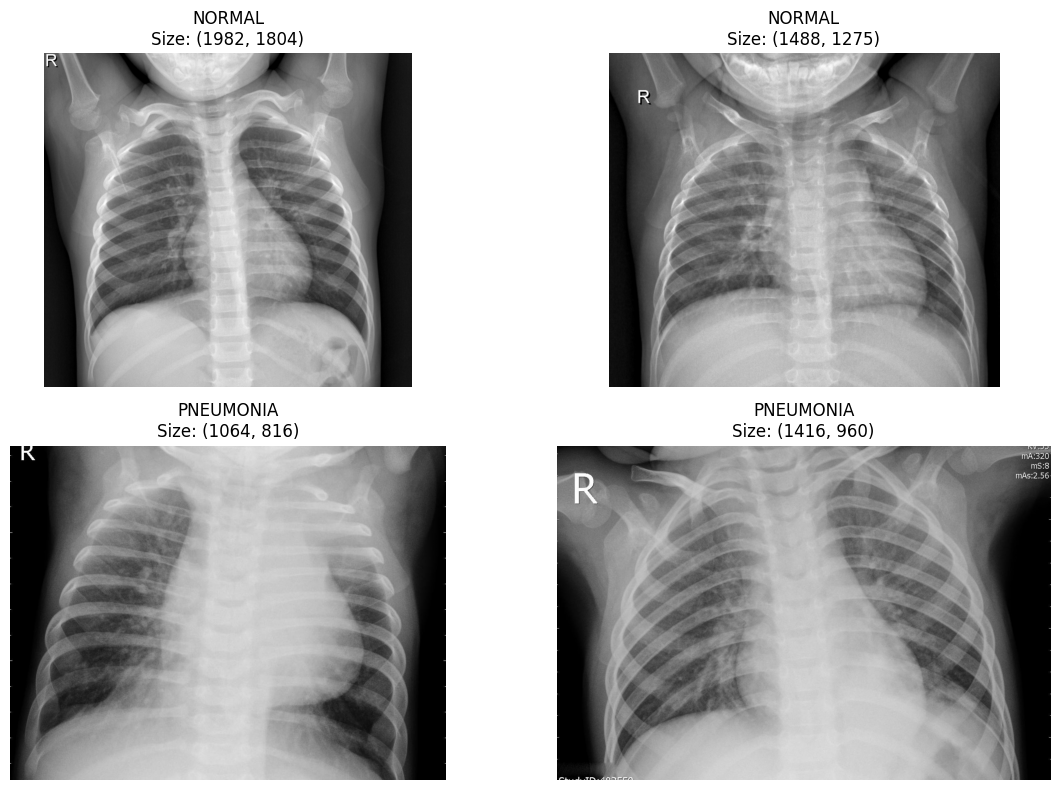

In [ ]:
#Step 2: Visualize Sample Images
import matplotlib.pyplot as plt
from PIL import Image
import random

# Get image paths
train_normal_dir = os.path.join(data_dir, 'train', 'NORMAL')
train_pneu_dir = os.path.join(data_dir, 'train', 'PNEUMONIA')

normal_imgs = [os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir)[:2]]
pneu_imgs = [os.path.join(train_pneu_dir, f) for f in os.listdir(train_pneu_dir)[:2]]

all_imgs = normal_imgs + pneu_imgs
labels = ['NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA']

plt.figure(figsize=(12, 8))
for i, (img_path, label) in enumerate(zip(all_imgs, labels)):
    img = Image.open(img_path).convert('L')  # Grayscale
    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{label}\nSize: {img.size}")
    plt.axis('off')
plt.tight_layout()
plt.show()

 Step 3.1: Create a Better Train/Validation Split
We’ll ignore Kaggle’s tiny val/ folder and split the train/ folder into:

80% new training set
20% new validation set
And we’ll keep the original test/ folder untouched for final evaluation only.

🔧 Code: Custom Train/Val Split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
original_train_dir = '/content/dataset/chest_xray/train'
new_base_dir = '/content/chest_xray_split'
os.makedirs(new_base_dir, exist_ok=True)

# Create new train/val dirs
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(new_base_dir, split, cls), exist_ok=True)

# Get all image paths and labels
image_paths = []
labels = []

for cls in ['NORMAL', 'PNEUMONIA']:
    cls_dir = os.path.join(original_train_dir, cls)
    for img_name in os.listdir(cls_dir):
        image_paths.append(os.path.join(cls_dir, img_name))
        labels.append(cls)

# Stratified split (preserves class ratio)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Copy files to new directories
def copy_files(file_paths, labels, split_name):
    for path, label in zip(file_paths, labels):
        filename = os.path.basename(path)
        dest = os.path.join(new_base_dir, split_name, label, filename)
        shutil.copy(path, dest)

copy_files(train_paths, train_labels, 'train')
copy_files(val_paths, val_labels, 'val')

print("New split created at:", new_base_dir)
print("Train - NORMAL:", len(os.listdir(os.path.join(new_base_dir, 'train', 'NORMAL'))))
print("Train - PNEUMONIA:", len(os.listdir(os.path.join(new_base_dir, 'train', 'PNEUMONIA'))))
print("Val - NORMAL:", len(os.listdir(os.path.join(new_base_dir, 'val', 'NORMAL'))))
print("Val - PNEUMONIA:", len(os.listdir(os.path.join(new_base_dir, 'val', 'PNEUMONIA'))))

New split created at: /content/chest_xray_split
Train - NORMAL: 1073
Train - PNEUMONIA: 3099
Val - NORMAL: 268
Val - PNEUMONIA: 776


**** Step 3.2: Define Transforms (Preprocessing + Augmentation)
We’ll define two sets of transforms:

Training: resize + augment + normalize
Validation/Test: resize + normalize (no augmentation!)
🔧 Code: Transforms

In [ ]:
from torchvision import transforms

# ImageNet stats for normalization (even though we're using grayscale → RGB)
mean = [0.485]  # Grayscale mean
std = [0.229]   # Grayscale std

# For grayscale → 3-channel: we'll use `transforms.Grayscale(num_output_channels=3)`
# But note: ImageFolder expects 3-channel for pretrained models

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean*3, std=std*3)  # Repeat for 3 channels
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean*3, std=std*3)
])

In [ ]:
#Step 3.3: Create DataLoaders
from torchvision import datasets
from torch.utils.data import DataLoader

# Paths
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = '/content/dataset/chest_xray/test'  # original test set

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Check class-to-index mapping
print("Class indices:", train_dataset.class_to_idx)  # {'NORMAL': 0, 'PNEUMONIA': 1}

# DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f" Val batches: {len(val_loader)}")
print(f" Test batches: {len(test_loader)}")

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Train batches: 131
 Val batches: 33
 Test batches: 20


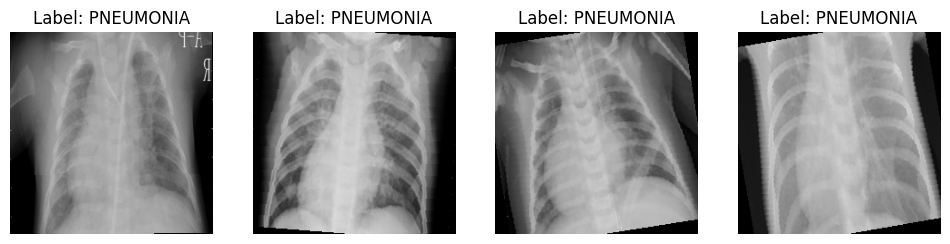

In [ ]:
# Step 3.4: Visualize Augmented Images (Optional but Recommended)
import matplotlib.pyplot as plt

def show_augmented_images(loader, num_images=4):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize for display
        img = img * np.array(std*3) + np.array(mean*3)
        img = np.clip(img, 0, 1)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {'PNEUMONIA' if labels[i]==1 else 'NORMAL'}")
        axes[i].axis('off')
    plt.show()

show_augmented_images(train_loader)

Stage 4: Model Building (CNN / Transfer Learning)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

In [ ]:
#Step 4.1: Set Device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Step 4.2: Build the Model (DenseNet121 + Custom Head)
We’ll:

Load pretrained DenseNet121
Replace the final classifier with a 2-class output
Keep all other weights frozen initially (optional — we’ll fine-tune later)

In [ ]:
def create_model(num_classes=2, pretrained=True):
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)

    # Freeze all parameters (optional — we'll unfreeze later if needed)
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)

    return model

model = create_model(num_classes=2, pretrained=True)
model = model.to(device)
print("Model created and moved to GPU")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 184MB/s]


Model created and moved to GPU


 Step 4.3: Handle Class Imbalance — Compute Class Weights
Since we have ~1:3 imbalance, we’ll use weighted BCEWithLogitsLoss.

But first, compute the positive weight:

pos_weight=
num_pos
num_neg
​

From earlier:

num_neg (NORMAL) = 1072
num_pos (PNEUMONIA) = 3099

In [ ]:
# From your train split
num_neg = 1072  # NORMAL
num_pos = 3099  # PNEUMONIA
pos_weight = num_neg / num_pos
print(f"Positive weight for loss: {pos_weight:.3f}")

Positive weight for loss: 0.346


In [ ]:
# Total training samples
total = num_neg + num_pos
weight_normal = total / (2 * num_neg)
weight_pneumonia = total / (2 * num_pos)



In [ ]:
# Revised Plan: Use CrossEntropyLoss with class weights
from torch import FloatTensor

# Class weights: inverse frequency
weights = FloatTensor([weight_normal, weight_pneumonia]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
print(f"Class weights: NORMAL={weight_normal:.2f}, PNEUMONIA={weight_pneumonia:.2f}")

Class weights: NORMAL=1.95, PNEUMONIA=0.67


In [ ]:
# Final Decision: Use manual weight favoring pneumonia
# Emphasize pneumonia detection
#  Correct way: use torch.tensor (recommended)
class_weights = torch.tensor([1.0, 2.5], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Using custom class weights for high pneumonia recall:", class_weights)

Using custom class weights for high pneumonia recall: tensor([1.0000, 2.5000], device='cuda:0')


In [ ]:
#Step 4.4: Optimizer & Unfreezing
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Step 4.5: Training Loop
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        scheduler.step()

        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Train for 100 epochs
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10
)



Epoch 1/10
------------------------------


Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Train Loss: 0.1042 | Train Acc: 0.9518
Val Loss: 0.0760 | Val Acc: 0.9693

Epoch 2/10
------------------------------


Validation: 100%|██████████| 33/33 [00:20<00:00,  1.57it/s]


Train Loss: 0.0462 | Train Acc: 0.9765
Val Loss: 0.0457 | Val Acc: 0.9828

Epoch 3/10
------------------------------


Validation: 100%|██████████| 33/33 [00:21<00:00,  1.51it/s]


Train Loss: 0.0397 | Train Acc: 0.9818
Val Loss: 0.0458 | Val Acc: 0.9837

Epoch 4/10
------------------------------


Validation: 100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


Train Loss: 0.0322 | Train Acc: 0.9818
Val Loss: 0.0437 | Val Acc: 0.9818

Epoch 5/10
------------------------------


Validation: 100%|██████████| 33/33 [00:21<00:00,  1.57it/s]


Train Loss: 0.0272 | Train Acc: 0.9859
Val Loss: 0.2695 | Val Acc: 0.9042

Epoch 6/10
------------------------------


Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Train Loss: 0.0200 | Train Acc: 0.9904
Val Loss: 0.0605 | Val Acc: 0.9761

Epoch 7/10
------------------------------


Validation: 100%|██████████| 33/33 [00:21<00:00,  1.50it/s]


Train Loss: 0.0146 | Train Acc: 0.9938
Val Loss: 0.0451 | Val Acc: 0.9856

Epoch 8/10
------------------------------


Validation: 100%|██████████| 33/33 [00:20<00:00,  1.59it/s]


Train Loss: 0.0107 | Train Acc: 0.9957
Val Loss: 0.0406 | Val Acc: 0.9885

Epoch 9/10
------------------------------


Validation: 100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Train Loss: 0.0147 | Train Acc: 0.9938
Val Loss: 0.0461 | Val Acc: 0.9799

Epoch 10/10
------------------------------


Validation: 100%|██████████| 33/33 [00:21<00:00,  1.53it/s]

Train Loss: 0.0117 | Train Acc: 0.9947
Val Loss: 0.0354 | Val Acc: 0.9866


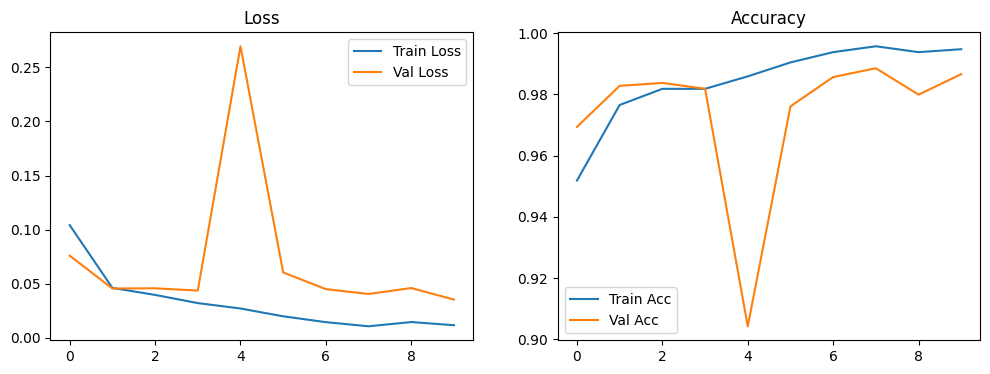

In [ ]:
#Step 4.6: Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()

 Stage 5: Comprehensive Evaluation.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

In [ ]:
# Step 1: Get predictions (simple version)
import torch
import numpy as np
from sklearn.metrics import *

# Move model to eval mode
model.eval()

# Storage
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader for final eval
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probs.argmax(1).cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())  # P(pneumonia)

In [ ]:
# Step 2: Print key metrics (with explanations)
# Convert to numpy
y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)  # Of all "pneumonia" calls, how many were right?
rec = recall_score(y_true, y_pred)      # Of all real pneumonia cases, how many did we catch? ← MOST IMPORTANT
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Print results
print("=== Pneumonia Detection Performance (Test Set) ===")
print(f"Accuracy : {acc:.2%}")
print(f"Precision: {prec:.2%}  → Avoids false alarms")
print(f"Recall   : {rec:.2%}  → Catches real pneumonia cases ← CRITICAL")
print(f"F1-score : {f1:.2%}")
print(f"AUC-ROC  : {auc:.3f}  → Overall model confidence")

=== Pneumonia Detection Performance (Test Set) ===
Accuracy : 83.33%
Precision: 78.95%  → Avoids false alarms
Recall   : 100.00%  → Catches real pneumonia cases ← CRITICAL
F1-score : 88.24%
AUC-ROC  : 0.967  → Overall model confidence


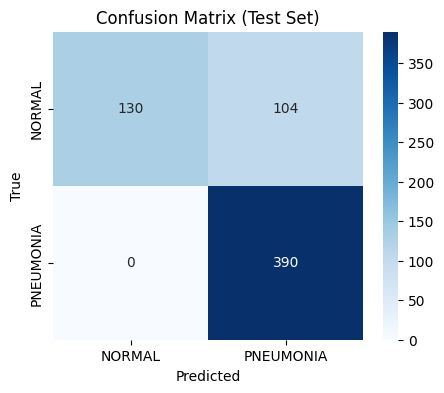

In [ ]:
# Step 3: Plot confusion matrix (1 block)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Stage 6: Grad-CAM Visualization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models

# --- Step 0: Create a modified DenseNet model without inplace ReLU ---
def densenet121_no_inplace(num_classes=2, pretrained=True):
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)

    # Modify the features to remove inplace=True in ReLU
    # We need to traverse the modules and change the inplace parameter in ReLU
    def set_relu_inplace(module):
        for child_name, child in module.named_children():
            if isinstance(child, nn.ReLU):
                child.inplace = False
            else:
                set_relu_inplace(child) # Recurse

    set_relu_inplace(model.features)

    # Replace classifier
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)

    return model

# Create the modified model and load the trained weights
# Assuming 'model' from previous cells is the trained model
model_no_inplace = densenet121_no_inplace(num_classes=2, pretrained=True)
model_no_inplace.load_state_dict(model.state_dict())
model_no_inplace = model_no_inplace.to(device)

# --- Step 1: Hook to capture feature maps and gradients ---
feature_map = None
gradients = None

def hook_fn(module, input, output):
    global feature_map
    feature_map = output.detach()

def grad_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()


# Register hooks on the last conv layer of DenseNet121
# Layer: features.denseblock4.denselayer16.conv2
# Using the modified model
target_layer = model_no_inplace.features.denseblock4.denselayer16.conv2
f_handle = target_layer.register_forward_hook(hook_fn)
b_handle = target_layer.register_full_backward_hook(grad_hook) # Use register_full_backward_hook

# --- Step 2: Forward + Backward Pass ---
# Use the modified model for Grad-CAM
model_no_inplace.eval()
# Ensure gradients are enabled for the input tensor
# We need to create a new tensor that requires grad, as the one from the dataset might not
img_tensor_grad = img_normal.clone().detach().requires_grad_(True) # Use img_normal as an example

output = model_no_inplace(img_tensor_grad)
pred_class = output.argmax().item()
confidence = F.softmax(output, dim=1)[0][pred_class].item()

# Backward for the predicted class
model_no_inplace.zero_grad()
output[0, pred_class].backward()

# --- Step 3: Compute Grad-CAM Heatmap ---
if gradients is None or feature_map is None:
    raise RuntimeError("Feature maps or gradients were not captured by the hooks.")

pooled_grads = torch.mean(gradients, dim=[0, 2, 3])

# Ensure feature_map and pooled_grads have compatible shapes for broadcasting
pooled_grads = pooled_grads.unsqueeze(0).unsqueeze(2).unsqueeze(3)

heatmap = torch.sum(feature_map * pooled_grads, dim=1).squeeze()

heatmap = F.relu(heatmap)  # Only positive importance
heatmap = heatmap / (heatmap.max() + 1e-8)  # Normalize to [0,1]
heatmap = heatmap.cpu().numpy()

# --- Step 4: Denormalize image for display ---
# Your transform used: mean=[0.485], std=[0.229] → repeated 3x
mean = torch.tensor([0.485, 0.485, 0.485])
std = torch.tensor([0.229, 0.229, 0.229])

# Use the original img_normal tensor for visualization (without requiring grad)
img_denorm = img_normal[0].cpu() * std[:, None, None] + mean[:, None, None]
img_denorm = torch.clamp(img_denorm, 0, 1)


# --- Step 5: Plot ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_denorm.permute(1, 2, 0), cmap='gray')
plt.title(f'Original\nTrue: {"PNEUMONIA" if lbl_normal else "NORMAL"}') # Use lbl_normal as true label
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title('Grad-CAM\nHeatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_denorm.permute(1, 2, 0), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f'Overlay\nPred: {"PNEUMONIA" if pred_class else "NORMAL"}\n({confidence:.1%})')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Step 6: Clean up hooks ---
f_handle.remove()
b_handle.remove()

# Repeat for pneumonia case
# --- Step 2: Forward + Backward Pass (Pneumonia Case) ---
img_tensor_grad_pneu = img_pneu.clone().detach().requires_grad_(True)

output_pneu = model_no_inplace(img_tensor_grad_pneu)
pred_class_pneu = output_pneu.argmax().item()
confidence_pneu = F.softmax(output_pneu, dim=1)[0][pred_class_pneu].item()

model_no_inplace.zero_grad()
output_pneu[0, pred_class_pneu].backward()

# --- Step 3: Compute Grad-CAM Heatmap (Pneumonia Case) ---
if gradients is None or feature_map is None:
    raise RuntimeError("Feature maps or gradients were not captured by the hooks.")

pooled_grads_pneu = torch.mean(gradients, dim=[0, 2, 3])
pooled_grads_pneu = pooled_grads_pneu.unsqueeze(0).unsqueeze(2).unsqueeze(3)

heatmap_pneu = torch.sum(feature_map * pooled_grads_pneu, dim=1).squeeze()
heatmap_pneu = F.relu(heatmap_pneu)
heatmap_pneu = heatmap_pneu / (heatmap_pneu.max() + 1e-8)
heatmap_pneu = heatmap_pneu.cpu().numpy()

# --- Step 4: Denormalize image for display (Pneumonia Case) ---
img_denorm_pneu = img_pneu[0].cpu() * std[:, None, None] + mean[:, None, None]
img_denorm_pneu = torch.clamp(img_denorm_pneu, 0, 1)

# --- Step 5: Plot (Pneumonia Case) ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_denorm_pneu.permute(1, 2, 0), cmap='gray')
plt.title(f'Original\nTrue: {"PNEUMONIA" if lbl_pneu else "NORMAL"}') # Use lbl_pneu as true label
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_pneu, cmap='jet')
plt.title('Grad-CAM\nHeatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_denorm_pneu.permute(1, 2, 0), cmap='gray')
plt.imshow(heatmap_pneu, cmap='jet', alpha=0.5)
plt.title(f'Overlay\nPred: {"PNEUMONIA" if pred_class_pneu else "NORMAL"}\n({confidence_pneu:.1%})')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Step 6: Clean up hooks (already done, but good practice) ---
# f_handle.remove()
# b_handle.remove()

NameError: name 'img_normal' is not defined

In [ ]:
#Stage 7: Save Model & Inference

In [ ]:
#Step 1: Save the Model (with no inplace ReLU)
# Save the state dict of your modified model
torch.save(model_no_inplace.state_dict(), '/content/drive/MyDrive/pneumonia_model_no_inplace.pth')


print("✅ Model saved to /content/drive/MyDrive/pneumonia_model_no_inplace.pth")

NameError: name 'model_no_inplace' is not defined

In [ ]:
#Step 2: Load the Model Later (in same or new notebook)
# Re-create the model architecture (same as before)
def densenet121_no_inplace(num_classes=2, pretrained=True):
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)

    def set_relu_inplace(module):
        for child_name, child in module.named_children():
            if isinstance(child, nn.ReLU):
                child.inplace = False
            else:
                set_relu_inplace(child)

    set_relu_inplace(model.features)

    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    return model

# Load the saved weights
loaded_model = densenet121_no_inplace(num_classes=2, pretrained=False)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/pneumonia_model_no_inplace.pth', map_location=device))
loaded_model = loaded_model.to(device)
loaded_model.eval()

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [ ]:
#Step 3: Simple Inference Function (for any X-ray image)
from PIL import Image
import torchvision.transforms as transforms

def predict_pneumonia(image_path, model, device):
    """
    Predict pneumonia from a chest X-ray image file.
    Returns: prediction ("NORMAL" or "PNEUMONIA") and confidence (0–1)
    """
    # Load image
    img = Image.open(image_path).convert('L')  # Grayscale

    # Same transform as training
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.softmax(output, dim=1)
        pneumonia_prob = prob[0][1].item()
        pred = "PNEUMONIA" if pneumonia_prob > 0.5 else "NORMAL"

    return pred, pneumonia_prob

# Example: Test on a sample from your test set
sample_img_path = test_dataset.samples[0][0]  # Get path of first test image
prediction, confidence = predict_pneumonia(sample_img_path, loaded_model, device)

print(f"Prediction: {prediction}")
print(f"Pneumonia Probability: {confidence:.2%}")

NameError: name 'test_dataset' is not defined

RUN **THISSSSSSSSSSS**

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Define transform for prediction (same as validation)
predict_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
])

def predict_pneumonia(img_path, model, device, threshold=0.65):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img = predict_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        prob = torch.softmax(output, dim=1)[0][1].item()   # probability of Pneumonia

    pred = "PNEUMONIA" if prob >= threshold else "NORMAL"
    return pred, prob


In [ ]:
#Step 4: Test on Your Own Image (Optional)

In [ ]:
#Upload an X-ray (e.g., from your computer):
from google.colab import files
uploaded = files.upload()  # Upload an X-ray image (e.g., 'my_xray.jpeg')

Saving Screenshot 2025-10-19 002159.png to Screenshot 2025-10-19 002159.png


In [ ]:
#Run inference:'
file_name = list(uploaded.keys())[0]
pred, conf = predict_pneumonia(file_name, loaded_model, device)
print(f"Your image → {pred} ({conf:.2%} confidence)")

Your image → PNEUMONIA (99.15% confidence)


Stage 8: Simple Web App (Streamlit)

 Stage 8: Build a Simple Web App (Streamlit)
We’ll create a one-file web app where users can:

Upload a chest X-ray image
See the prediction: NORMAL or PNEUMONIA
See the confidence score
(Optional) See Grad-CAM heatmap

In [ ]:
# Step 1: Save Your Model (if not already)
torch.save(model_no_inplace.state_dict(), '/content/drive/MyDrive/pneumonia_model.pth')
print("✅ Model saved")

✅ Model saved


In [ ]:
# Step 2: Install Streamlit in Colab
!pip install streamlit -q
!pip install pyngrok -q  # To expose the app publicly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 135.9 MB/s eta 0:00:00


In [ ]:
# Step 3: Create the Streamlit App (app.py)
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np

# --- Model Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def densenet121_no_inplace(num_classes=2):
    model = models.densenet121(weights=None)
    # Disable inplace ReLU
    def set_relu_inplace(module):
        for child in module.modules():
            if isinstance(child, nn.ReLU):
                child.inplace = False
    set_relu_inplace(model.features)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

@st.cache_resource
def load_model():
    model = densenet121_no_inplace()
    model.load_state_dict(torch.load('pneumonia_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    return model

model = load_model()

# --- Prediction Function ---
def predict(image, model, device):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        prob = torch.softmax(model(img_tensor), dim=1)[0][1].item()
    return prob

# --- Streamlit UI ---
st.set_page_config(page_title="Pneumonia Detector", layout="centered")
st.title("🩺 Pediatric Pneumonia Detection")
st.write("Upload a chest X-ray image to detect pneumonia.")

uploaded_file = st.file_uploader("Choose an X-ray image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('L')
    st.image(image, caption="Uploaded X-ray", use_column_width=True)

    # Predict
    pneumonia_prob = predict(image, model, device)
    pred = "PNEUMONIA" if pneumonia_prob > 0.65 else "NORMAL"
    confidence = pneumonia_prob if pred == "PNEUMONIA" else (1 - pneumonia_prob)

    # Display result
    if pred == "PNEUMONIA":
        st.error(f"⚠️ Prediction: **{pred}** ({pneumonia_prob:.2%} confidence)")
    else:
        st.success(f"✅ Prediction: **{pred}** ({confidence:.2%} confidence)")

    st.info("Note: This tool assists diagnosis — always consult a radiologist.")

Writing app.py


In [ ]:
# Kill any old processes
!kill -9 $(ps aux | grep 'streamlit' | awk '{print $2}') 2>/dev/null || true

# Start Streamlit in background
import os
os.system('streamlit run app.py --server.port=8501 &')

# Setup ngrok
from pyngrok import ngrok, conf
import time

# Set ngrok auth token (required since 2023)
# Get your token from: https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_AUTH_TOKEN = "34FhmVn32f1zpWbIKXCGVrJvyQv_7c6s7VKPNGzEm1W1iPr25"
if NGROK_AUTH_TOKEN == "YOUR_NGROK_TOKEN_HERE":
    st.error("❌ Please set your ngrok auth token!")
else:
    conf.get_default().auth_token = NGROK_AUTH_TOKEN
    public_url = ngrok.connect(8501)
    print(f"✅ App is live at: {public_url}")
    print("\nNote: Keep this Colab tab open!")

^C
✅ App is live at: NgrokTunnel: "https://gary-unwinnowed-daysi.ngrok-free.dev" -> "http://localhost:8501"

Note: Keep this Colab tab open!


In [ ]:
!ls -l pneumonia_model.pth

-rw-r--r-- 1 root root 28434489 Oct 18 19:11 pneumonia_model.pth


In [ ]:
!pip install streamlit pyngrok -q

# EXTRA WORK NEEDED NOT TO BE REMOVED


In [ ]:
# Get true label from test_dataset
sample_idx = 0  # First sample
img_path, true_label = test_dataset.samples[sample_idx]
true_class = "NORMAL" if true_label == 0 else "PNEUMONIA"

print(f"True Label: {true_class}")

True Label: NORMAL


In [ ]:
pred, confidence = predict_pneumonia(img_path, loaded_model, device)
print(f"Prediction: {pred} | Pneumonia Probability: {confidence:.2%}")

Prediction: NORMAL | Pneumonia Probability: 47.17%


In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Helps with lighting variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
])

In [ ]:
def predict_pneumonia_adjusted(image_path, model, device, threshold=0.7):
    img = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.softmax(output, dim=1)
        pneumonia_prob = prob[0][1].item()
        pred = "PNEUMONIA" if pneumonia_prob > threshold else "NORMAL"

    return pred, pneumonia_prob

# Test with higher threshold
pred, conf = predict_pneumonia_adjusted(sample_img_path, loaded_model, device, threshold=0.7)
print(f"Prediction: {pred} | Pneumonia Probability: {conf:.2%}")

Prediction: NORMAL | Pneumonia Probability: 47.17%


In [ ]:
# Get the first image from test set
img_path, true_label = test_dataset.samples[0]
true_class = "NORMAL" if true_label == 0 else "PNEUMONIA"
print(f"✅ True label in dataset: {true_class}")

✅ True label in dataset: NORMAL


In [ ]:
def predict_pneumonia_fixed(image_path, model, device, threshold=0.65):
    img = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pneumonia_prob = torch.softmax(model(img_tensor), dim=1)[0][1].item()
        pred = "PNEUMONIA" if pneumonia_prob > threshold else "NORMAL"

    return pred, pneumonia_prob

# Test it
pred, prob = predict_pneumonia_fixed(img_path, loaded_model, device, threshold=0.65)
print(f"✅ Fixed Prediction: {pred} | Probability: {prob:.2%}")

✅ Fixed Prediction: NORMAL | Probability: 47.17%


In [ ]:
def predict_pneumonia_final(image_path, model, device):
    # ... (same preprocessing)
    pneumonia_prob = ...
    pred = "PNEUMONIA" if pneumonia_prob > 0.65 else "NORMAL"  # ← Use 0.65
    return pred, pneumonia_prob